# Install, importar librerías y montar Drive

In [ ]:
! pip install nibabel
! pip install nilabels
! pip install nilearn
! pip install antspyx
! pip install --upgrade gspread

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nibabel as nib
import nilabels as nis
import numpy as np
import nilearn as nil
from nilearn import plotting, image, regions, masking
import matplotlib.pyplot as plt
import ants
import gspread
from google.colab import drive, auth
from google.auth import default
import os
from os import listdir
import cv2
import pandas as pd
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [ ]:
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Cargar imagenes

Las imágenes de los pacientes se obtuvieron de la base de datos **PPMI**.

La imagen de referencia y la imagen con 16 estructuras subcorticales se obtuvieron del atlas **MNIPD25-T1MPRAGE-1 mm** (https://nist.mni.mcgill.ca/multi-contrast-pd25-atlas/).

Las imagenes se cargan utilizando la función `image_read` de la libreria **ANTsPy** (https://antspy.readthedocs.io/en/latest/index.html). Esta tiene de parámetro la ruta al archivo NIfTI y devuelve la imagen como  objeto `ANTsImage`, permitiendo procesar la imagen con las funciones de esta librería.

In [ ]:
# Acceder al archivo con los datos de los pacientes
creds, _ = default()
gc = gspread.authorize(creds)
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1gCz6iD2wwd6bg_QvSacfEw9R5VdNpYZLskgdtT9rwLE/edit?usp=share_link').sheet1
# Link al Google Sheet de acceso publico

In [ ]:
num_pacientes =  tuple(list(np.concatenate(worksheet.get_values('B2:B41', value_render_option = 'UNFORMATTED_VALUE')).flat))
grupo_pacientes = tuple(list(np.concatenate(worksheet.get_values('C2:C41', value_render_option = 'UNFORMATTED_VALUE')).flat))

In [ ]:
imgs_pacientes_ants_lista = []

dir_carpeta = "/content/drive/MyDrive/TP PIB/Imagenes Pacientes"

for i in num_pacientes:
  img_paciente = ants.image_read(f'{dir_carpeta}/PPMI_{i}_MR_MPRAGE_GRAPPA.nii')
  imgs_pacientes_ants_lista.append(img_paciente)

imgs_pacientes_ants = tuple(imgs_pacientes_ants_lista)

A lo largo del trabajo utilizamos a la img_21 como ejemplo para visualizar los pasos que se van realizando.

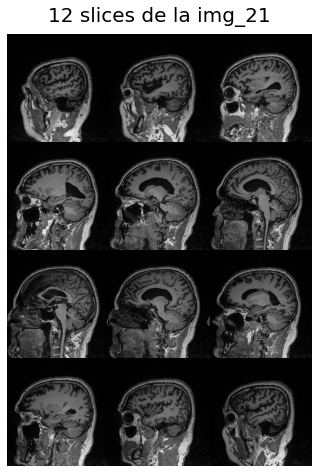

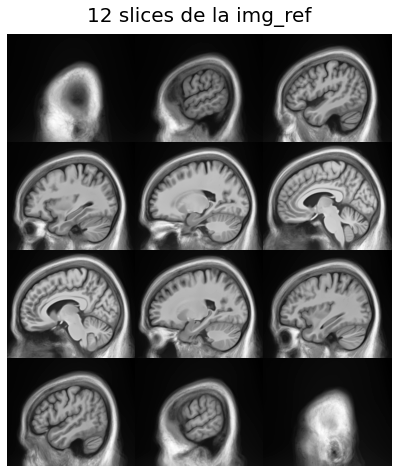

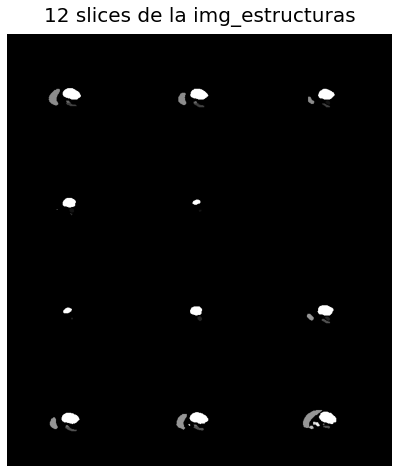

In [ ]:
# Elijo una img de img_pacientes para graficar como ejemplo
img_21_ants = imgs_pacientes_ants[21]
ants.plot(img_21_ants, title = "12 slices de la img_21") # graficar img_21
plt.show()

# img_ref es la img de MRI de referencia del atlas
img_ref_ants = ants.image_read('/content/drive/MyDrive/TP PIB/Imagenes Atlas/PD25-T1MPRAGE-template-1mm.nii')
ants.plot(img_ref_ants, title = "12 slices de la img_ref") # graficar img_ref
plt.show()

# img_estructuras es la img de MRI que contiene solo 16 estructuras subcorticales del cerebro
img_estructuras_ants = ants.image_read('/content/drive/MyDrive/TP PIB/Imagenes Atlas/PD25-subcortical-1mm.nii')
ants.plot(img_estructuras_ants, title = "12 slices de la img_estructuras") # graficar img_estructuras
plt.show()

A continuación se imprimen las dimensiones de las imágenes de la base de datos y las imágenes del atlas. Como esperabamos, tienen distintas dimensiones. Esto se ve también en el tamaño de las imágenes de se graficaron arriba.

In [ ]:
lista_shape_imgs = [['Imagen fija', f'{img_ref_ants.shape}'], ['Imagen con estructuras subcorticales', f'{img_estructuras_ants.shape}']]

for i in range(len(num_pacientes)):
  datos = [f'Img paciente {num_pacientes[i]}', f'{imgs_pacientes_ants[i].shape}']
  lista_shape_imgs.append(datos)

tabla = tabulate(lista_shape_imgs, headers=['Imagen', 'Dimensiones'])
print(tabla)

Imagen                                Dimensiones
------------------------------------  ---------------
Imagen fija                           (193, 229, 193)
Imagen con estructuras subcorticales  (193, 229, 193)
Img paciente 3102                     (176, 240, 256)
Img paciente 3104                     (176, 240, 256)
Img paciente 3105                     (176, 240, 256)
Img paciente 3106                     (176, 240, 256)
Img paciente 3107                     (176, 240, 256)
Img paciente 3108                     (176, 240, 256)
Img paciente 3111                     (176, 240, 256)
Img paciente 3112                     (176, 240, 256)
Img paciente 3113                     (176, 240, 256)
Img paciente 3114                     (176, 240, 256)
Img paciente 3115                     (176, 240, 256)
Img paciente 3116                     (176, 240, 256)
Img paciente 3118                     (176, 240, 256)
Img paciente 3119                     (176, 240, 256)
Img paciente 3120               

Esto nos recuerda que debemos realizar la registración de las imágenes de los paciente antes de segmentarla con la imagen del atlas!

# Registración

Primero debemos hacer la registración. Esto es necesario ya que las imagenes de los pacientes obtenidas de la base de datos PPMI pertenecen a distintos centros, pacientes y días, por lo que contienen diferencias espaciales y temporales. Como imagen fija o de referencia se utiliza la imagen **PD25-T1MPRAGE-template** en 1 mm, del atlas previamente mencionado.

Se utiliza la función ```registration``` de ANTsPy. Esta tiene como argumentos la imagen de referencia, la imagen móvil y el tipo de registración. Se decidió utilizar el método **“SyN”**, el cual es una normalización simétrica que realiza transformaciones afines y elásticas, con información mutua como métrica de optimización. Esta función devuelve un diccionario que contiene 4 pares llave/valor:
1. La llave `warpedmovout` cuyo valor es la imagen móvil transformada al espacio de la imagen fija.
2. La llave `warpedfixout` cuyo valor es la imagen fija transformada al espacio de la imagen móvil.
3. La llave `fwdtransforms` cuyo valor es la función de transformación para mover la imagen móvil al espacio de la imagen fija.
4. La llave `invtransforms` cuyo valor es la función de transformación para mover la imagen fija al espacio de la imagen móvil.

En este caso se desea trabajar con la imagen móvil registrada con la imagen fija, por lo que utilizaremos la imagen de la llave `warpedmovout`.



In [ ]:
def registracionAnts(imgs_moviles_ants, img_ref_ants):

  imgs_reg_ants_lista = []

  for i in range(len(imgs_moviles_ants)):
    img_result_reg = ants.registration(fixed = img_ref_ants, moving = imgs_moviles_ants[i], type_of_transform='SyN') # Realizo registracion con ANTsPy
    img_reg_ants = img_result_reg.get('warpedmovout') # Obtengo la img móvil transformada
    imgs_reg_ants_lista.append(img_reg_ants) # Guardo cada img registrada en una lista

  imgs_reg_ants = tuple(imgs_reg_ants_lista) # Paso la lista a tupla para que no se puedan cambiar de lugar las imgs

  return imgs_reg_ants

In [ ]:
imgs_pacientes_reg_ants = registracionAnts(imgs_pacientes_ants, img_ref_ants)

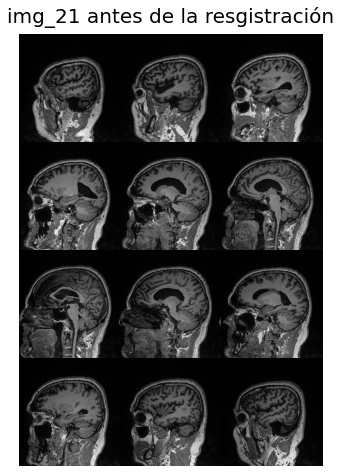

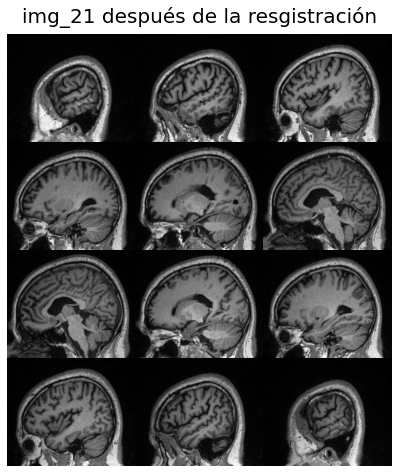

In [ ]:
ants.plot(img_21_ants, title = "img_21 antes de la resgistración")
ants.plot(imgs_pacientes_reg_ants[21], title = "img_21 después de la resgistración")

# Segmentación

Para la segmentación de las imágenes se armó la siguiente función en la cual se utilizan funciones de las dos librerías para seleccionar la ROI de la imagen con las estructuras, usarla como máscara para segmentar las imágenes de los pacientes y luego guardar los resultados de la segmentación en formato Nibabel, ya que después se obtienen los arreglos de Numpy con los cuales se hará el análisis de texturas.

In [ ]:
def segmentar_ROIs(img_paciente_ants, img_estructuras_ants, ROI_labels_nums):

  lista_ROI = []

  for i in range(len(ROI_labels_nums)):

    # Paso 1: pasamos la img_estructuras_ants a Nibabel y seleccionamos la ROI utilizando su label
    img_estructuras_nilearn = ants.to_nibabel(img_estructuras_ants)
    img_ROI = image.math_img('img == %s' % ROI_labels_nums[i], img = img_estructuras_nilearn)

    # Paso 2: pasamos la img_ROI a formato ants
    img_ROI_ants = ants.from_nibabel(img_ROI)

    # Paso 3: segmentamos la ROI de la imagen del paciente utilizando la img_ROI como máscara
    img_paciente_ROI = ants.mask_image(image=img_paciente_ants, mask=img_ROI_ants)

    # Paso 4: guardamos en una lista la segmentación en formato Nilearn
    lista_ROI.append(ants.to_nibabel(img_paciente_ROI))

  # Por ultimo, hacemos de la lista una tupla para no permitir que se cambie el orden de las estructuras,
  # asi quedan en el mismo orden que los nombres en la tupla de nombres.
  ROI_paciente = tuple(lista_ROI)

  return ROI_paciente

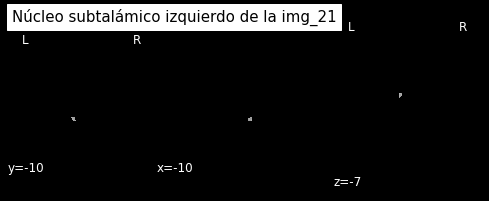

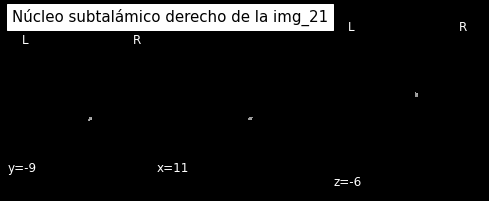

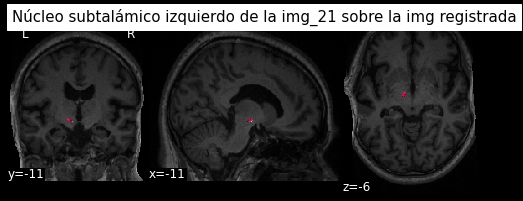

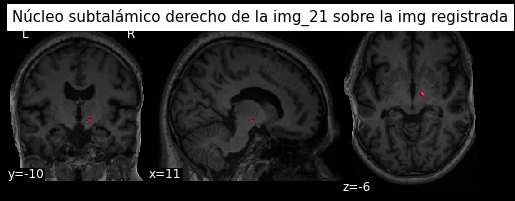

In [ ]:
# El atlas provee la siguiente informacion sobre las etiquetas y a que estructura identifica cada una:
# ROI_labels_nums = (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)
# ROI_labels_nombres = ('Núcleo rojo izquierdo', 'Núcleo rojo derecho', 'Sustancia negra izquierda', 'Sustancia negra derecha', 'Núcleo subtalámico izquierdo', 'Núcleo subtalámico derecho', 'Lóbulo caudado izquierdo', 'Lóbulo caudado derecho', 'Putamen izquierdo', 'Putamen derecho', 'Globo pálido externo izquierdo', 'Globo pálido externo derecho', 'Globo pálido interno izquierdo', 'Globo pálido interno derecho', 'Tálamo izquierdo', 'Tálamo derecho')

# Solo queremos segmentar los núcleos subtalámicos:
ROI_labels_nums = (5, 6)
ROI_labels_nombres = ('Núcleo subtalámico izquierdo', 'Núcleo subtalámico derecho')

NSI_pacientes = [] # NSI: núcleo subtalámico izquierdo
NSD_pacientes = [] # NSD: núcleo subtalámico derecho

for i in range(len(imgs_pacientes_reg_ants)):
  ROI_paciente_nilearn = segmentar_ROIs(imgs_pacientes_reg_ants[i], img_estructuras_ants, ROI_labels_nums)
  NSI_pacientes.append(image.get_data(ROI_paciente_nilearn[0]))
  NSD_pacientes.append(image.get_data(ROI_paciente_nilearn[1]))

  if i == 21:
    plotting.plot_anat(anat_img=ROI_paciente_nilearn[0], draw_cross = False, title=f"{ROI_labels_nombres[0]} de la img_21")
    plt.show()

    plotting.plot_anat(anat_img=ROI_paciente_nilearn[1], draw_cross = False, title=f"{ROI_labels_nombres[1]} de la img_21")
    plt.show()

    plotting.plot_roi(roi_img=ROI_paciente_nilearn[0], bg_img=ants.to_nibabel(imgs_pacientes_reg_ants[21]), draw_cross =False, cmap=plotting.cm.black_pink, title=f"{ROI_labels_nombres[0]} de la img_21 sobre la img registrada")
    plotting.show()

    plotting.plot_roi(roi_img=ROI_paciente_nilearn[1], bg_img=ants.to_nibabel(imgs_pacientes_reg_ants[21]), draw_cross =False, cmap=plotting.cm.black_pink, title=f"{ROI_labels_nombres[1]} de la img_21 sobre la img registrada")
    plotting.show()

# Análisis de texturas

Primero tenemos las funciones vistas en clase.

## Matriz de concurrencia

In [ ]:
def Coocurrencia(img,dir):
  filas = img.shape[0]
  cols = img.shape[1]

  max = int(np.max(img))
  min = int(np.min(img))

  if max-min == 0:
    matriz = np.ones((1,1))
  else:
    #creo la matriz teniendo en cuenta los valores mínimo y máximo de gris de la imagen
    matriz = np.zeros((max-min+1,max-min+1))

    if dir==0:
      #Dirección horizontal
      for i in range(filas):
        for j in range(cols-1):
          a = int(img[i,j])
          b = int(img[i,j+1])
          indice_a = a-min
          indice_b = b-min
          matriz[indice_a,indice_b]+=1
          matriz[indice_b,indice_a]+=1
          #Como hacer la traaspuesta pero lo hago paso por paso
          #sumo en la posición de la transición y en la posición simétrica
          #si llega a ser de la diagonal se suma dos veces

    if dir==45:
      #Dirección diagonal para abajo
      for i in range(1,filas):
        for j in range(cols-1):
          a = int(img[i,j])
          b = int(img[i-1,j+1])
          indice_a = a-min
          indice_b = b-min
          matriz[indice_a,indice_b]+=1
          matriz[indice_b,indice_a]+=1
          #sumo en la posición de la transición y en la posición simétrica
          #si llega a ser de la diagonal se suma dos veces

    if dir==90:
      #Dirección vertical
      for i in range(filas-1):
        for j in range(cols):
          a = img[i,j]
          b = img[i+1,j]
          indice_a = a-min
          indice_b = b-min
          matriz[indice_a,indice_b]+=1
          matriz[indice_b,indice_a]+=1
          #sumo en la posición de la transición y en la posición simétrica
          #si llega a ser de la diagonal se suma dos veces

    if dir==135:
      #Dirección diagonal para arriba
      for i in range(filas-1):
        for j in range(cols-1):
          a = img[i,j]
          b = img[i+1,j+1]
          indice_a = a-min
          indice_b = b-min
          matriz[indice_a,indice_b]+=1
          matriz[indice_b,indice_a]+=1
          #sumo en la posición de la transición y en la posición simétrica
          #si llega a ser de la diagonal se suma dos veces


    #Normalizo la matriz
    factor =  2*((max-min+1)**2)
    matriz = matriz/factor
  return matriz, min

## Media

In [ ]:
def Media(matriz, min):
  filas = matriz.shape[0]
  cols = matriz.shape[1]

  media = 0
  for i in range(filas):
    for j in range(cols):
      media += (i+min)*matriz[i,j]

  return media

## Desvio

In [ ]:
def Desvio(matriz,media,min):
  filas = matriz.shape[0]
  cols = matriz.shape[1]

  desvio = 0
  for i in range(filas):
    for j in range(cols):
      desvio += ((i+min-media)**2)*matriz[i,j]

  return desvio

## Entropía

In [ ]:
def Entropia(matriz):
  filas = matriz.shape[0]
  cols = matriz.shape[1]

  entropia = 0
  for i in range(filas):
    for j in range(cols):
      if (matriz[i,j] != 0):
        entropia += matriz[i,j]*np.log2(matriz[i,j])

  return entropia

## Energía

In [ ]:
def Energia(matriz):
  filas = matriz.shape[0]
  cols = matriz.shape[1]

  energia = 0
  for i in range(filas):
    for j in range(cols):
      energia += matriz[i,j]**2

  return energia

## Momento de diferencia inversa

In [ ]:
def IDM(matriz):
  filas = matriz.shape[0]
  cols = matriz.shape[1]

  idm = 0
  for i in range(filas):
    for j in range(cols):
      idm += matriz[i,j]/(1 + (i-j)**2)

  return idm

## Correlación

In [ ]:
def Correlacion(matriz,media,desvio,min):
  filas = matriz.shape[0]
  cols = matriz.shape[1]

  correlacion = 0
  for i in range(filas):
    for j in range(cols):
      correlacion += ((i+min-media)*(j+min-media)*matriz[i,j])/(desvio**2)

  return correlacion

## Contraste

In [ ]:
def Contraste(matriz):
  filas = matriz.shape[0]
  cols = matriz.shape[1]

  contraste = 0
  for i in range(filas):
    for j in range(cols):
      contraste += ((i-j)**2)*matriz[i,j]

  return contraste

## Cluster shade

In [ ]:
def ClusterShade(matriz,min):
  filas = matriz.shape[0]
  cols = matriz.shape[1]

  cluster = 0
  for i in range(filas):
    for j in range(cols):
      cluster += matriz[i,j]*((i+min+j+min)**3)
  return cluster

En la siguiente función se calculan las métricas para cada estructura segmentada de cada imagen. Las métricas se calculan en 2 dimensiones, es decir se toma cada slice y se calculan las métricas en esta "imagen" 2D. Estos resultados parciales se promedian para finalmente obtener la métrica de toda la estructura.

## Calcular métricas

In [ ]:
def calcularMetricasTextura(img_ROI):

  suma_entropia = 0
  suma_energia = 0
  suma_idm = 0
  suma_correlacion = 0
  suma_contraste = 0
  suma_CS = 0

  num_slices = 0

  for i in range(img_ROI.shape[0]):

    slice_mri = img_ROI[i,:,:].T  # Se hace el analisis de texturas a cada slice de la img tomanda en el plano sagital

    for n in range(slice_mri.shape[0]):

      end = False

      for m in range(slice_mri.shape[1]):

        pixel = slice_mri[n,m]

        if pixel != 0: # No se toman en cuenta las slices que no contienen información

          # Se calculan las métricas y se van sumando

          # Matriz de concurrencia
          matriz, min = Coocurrencia(slice_mri,0)

          # Media
          media = Media(matriz, min)

          # Desvio
          desvio = Desvio(matriz,media,min)

          # Entropia
          entropia = Entropia(matriz)
          suma_entropia += entropia

          # Energia
          energia = Energia(matriz)
          suma_energia += energia

          # IDM
          idm = IDM(matriz)
          suma_idm += idm

          # Correlacion
          correlacion = Correlacion(matriz,media,desvio,min)
          suma_correlacion += correlacion

          # Contraste
          contraste = Contraste(matriz)
          suma_contraste += contraste

          # Cluste shade
          cluster_shade = ClusterShade(matriz,min)
          suma_CS += cluster_shade

          end = True
          num_slices += 1
          break

      if end == True:
        break

  # La métrica final para cada imagen es el promedio de la métrica en cada slice
  prom_entropia = suma_entropia/num_slices
  prom_energia = suma_energia/num_slices
  prom_idm = suma_idm/num_slices
  prom_correlacion = suma_correlacion/num_slices
  prom_contraste = suma_contraste/num_slices
  prom_CS = suma_CS/num_slices

  # Se guardan las métricas de una img en una lista
  metricas_textura = [prom_entropia, prom_energia, prom_idm, prom_correlacion, prom_contraste, prom_CS]

  return metricas_textura

Ahora se guardan los resultados de cada estructura en un array distinto. Esto es necesario para poder comprender mejor los datos disponibles que serán utilizados en el armado del clasificador binario con machine learning.

In [ ]:
entropia_NSI = []
energia_NSI  = []
idm_NSI  = []
corr_NSI  = []
contraste_NSI  = []
cs_NSI  = []

for i in range(len(NSI_pacientes)):
  NSI_paciente = NSI_pacientes[i]
  metricas_textura = calcularMetricasTextura(NSI_paciente)

  entropia_NSI.append(metricas_textura[0])
  energia_NSI.append(metricas_textura[1])
  idm_NSI.append(metricas_textura[2])
  corr_NSI.append(metricas_textura[3])
  contraste_NSI.append(metricas_textura[4])
  cs_NSI.append(metricas_textura[5])

In [ ]:
entropia_NSD = []
energia_NSD  = []
idm_NSD  = []
corr_NSD  = []
contraste_NSD  = []
cs_NSD  = []

for i in range(len(NSD_pacientes)):
  NSD_paciente = NSD_pacientes[i]
  metricas_textura = calcularMetricasTextura(NSD_paciente)

  entropia_NSD.append(metricas_textura[0])
  energia_NSD.append(metricas_textura[1])
  idm_NSD.append(metricas_textura[2])
  corr_NSD.append(metricas_textura[3])
  contraste_NSD.append(metricas_textura[4])
  cs_NSD.append(metricas_textura[5])

# Machine learning

## Data frame

Primero debemos crear el data frame con los datos que utilizaremos como carcterísticas de las imágenes: las 6 métricas del núcleo subtalámico izquierdo y las 6 del derecho. Junto a estas, debemos agregar el grupo al cual pertenece el paciente: grupo control (0) o enfermedad de Parkinson (1).

In [ ]:
# Creación de diccionario
diccionario = {}

for i in range(0, len(np.array(entropia_NSI))):
  diccionario[i] = {'entropia SNI': np.array(entropia_NSI)[i],
                    'energia SNI': np.array(energia_NSI)[i],
                    'idm SNI': np.array(idm_NSI)[i],
                    'correlacion SNI': np.array(corr_NSI)[i],
                    'contraste SNI': np.array(contraste_NSI)[i],
                    'cluster shade SNI': np.array(cs_NSI)[i],
                    'entropia SND': np.array(entropia_NSD)[i],
                    'energia SND': np.array(energia_NSD)[i],
                    'idm SND': np.array(idm_NSD)[i],
                    'correlacion SND': np.array(corr_NSD)[i],
                    'contraste SND': np.array(contraste_NSD)[i],
                    'cluster shade SND': np.array(cs_NSD)[i],
                    'grupo': np.array(grupo_pacientes)[i]}

# Creación de DataFrame
df = pd.DataFrame()

df['Entropia SNI'] = [value['entropia SNI'] for value in diccionario.values()]
df['Energia SNI'] = [value['energia SNI'] for value in diccionario.values()]
df['IDM SNI'] = [value['idm SNI'] for value in diccionario.values()]
df['Correlacion SNI'] = [value['correlacion SNI'] for value in diccionario.values()]
df['Contraste SNI'] = [value['contraste SNI'] for value in diccionario.values()]
df['Cluster shade SNI'] = [value['cluster shade SNI'] for value in diccionario.values()]
df['Entropia SND'] = [value['entropia SND'] for value in diccionario.values()]
df['Energia SND'] = [value['energia SND'] for value in diccionario.values()]
df['IDM SND'] = [value['idm SND'] for value in diccionario.values()]
df['Correlacion SND'] = [value['correlacion SND'] for value in diccionario.values()]
df['Contraste SND'] = [value['contraste SND'] for value in diccionario.values()]
df['Cluster shade SND'] = [value['cluster shade SND'] for value in diccionario.values()]
df['Grupo'] = [value['grupo'] for value in diccionario.values()]

In [ ]:
df.T

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
Entropia SNI,-0.526392,-0.520757,-0.517747,-0.526221,-0.499793,-0.519986,-0.529554,-0.529032,-0.502889,-0.517177,...,-0.439623,-0.531801,-0.519299,-0.510148,-0.510293,-0.524442,-0.456221,-0.530819,-0.515495,-0.466172
Energia SNI,0.099676,0.088204,0.081541,0.101318,0.061747,0.204347,0.112189,0.125471,0.065298,0.084661,...,0.030201,0.119427,0.084538,0.219607,0.218746,0.092376,0.036151,0.117542,0.219397,0.040296
IDM SNI,0.314989,0.295996,0.285083,0.317124,0.247837,0.450971,0.333952,0.351513,0.254422,0.289044,...,0.173573,0.345166,0.290113,0.463235,0.462175,0.303843,0.189851,0.342002,0.467886,0.200522
Correlacion SNI,0.061786,0.063808,0.066671,0.064311,0.063104,0.063842,0.064189,0.063113,0.063465,0.061376,...,0.065511,0.064686,0.064774,0.063717,0.063936,0.064228,0.063033,0.064821,0.063545,0.062777
Contraste SNI,6.209685,6.034964,5.828336,6.121533,6.080587,6.154859,6.086215,6.086991,6.143559,6.225110,...,5.890995,5.901044,5.932934,6.061605,6.045889,6.123193,6.106456,5.951414,6.004324,6.209049
Cluster shade SNI,32428.830418,31873.069227,30694.345026,28884.499023,34861.027072,26044.004163,28976.453802,29457.497342,35066.813748,34222.037076,...,39765.594241,28478.061125,30870.305380,25309.454363,25222.160598,31909.346055,41193.316752,28936.073133,24819.594665,40282.247503
Entropia SND,-0.521000,-0.518474,-0.514053,-0.524717,-0.505366,-0.519265,-0.531645,-0.528647,-0.497536,-0.522852,...,-0.452775,-0.529545,-0.521518,-0.512831,-0.513120,-0.529398,-0.452741,-0.530991,-0.511670,-0.474256
Energia SND,0.087427,0.083448,0.076982,0.096125,0.066338,0.198435,0.121667,0.115619,0.060130,0.091184,...,0.034927,0.136629,0.088960,0.219503,0.218237,0.109904,0.035378,0.115515,0.225961,0.045492
IDM SND,0.295154,0.288224,0.276824,0.309252,0.257255,0.442422,0.348233,0.338126,0.244441,0.301385,...,0.186537,0.366879,0.297574,0.465741,0.464243,0.330858,0.187236,0.339466,0.473780,0.212007
Correlacion SND,0.069691,0.068612,0.071684,0.071165,0.070146,0.069198,0.066646,0.069281,0.069819,0.067587,...,0.069698,0.068807,0.067093,0.068214,0.068342,0.066211,0.069532,0.072191,0.069656,0.066855


## Clasificador

Ahora sí podemos armar el clasificador, utilizando funciones de la librería sklearn.

Para el tamaño de los datasets de prueba y entrenamiento se probaron distintos valores y se eligieron los que dan un mayor accuracy score.

(32, 12)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.



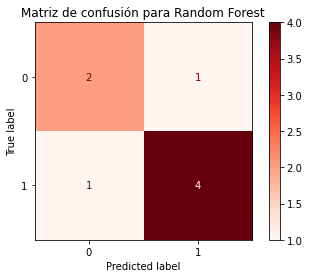

In [ ]:
clf_RF = RandomForestClassifier(random_state=0)

target_names=np.array(['0','1'])

X = df.T[:12]
y = df.T[-1:]
class_names = target_names

# División de los datos en un conjunto de entrenamiento y un conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X.T, np.ravel(y.T), test_size=0.2, train_size=0.8, random_state=0)

# Ejecución del clasificador y entrenamiento
clf_RF.fit(X_train, y_train)
print(X_train.shape)

disp = plot_confusion_matrix(clf_RF, X_test, y_test, display_labels=class_names, cmap=plt.cm.Reds)
disp.ax_.set_title("Matriz de confusión para Random Forest")
plt.show()

In [ ]:
y_pred_RF = clf_RF.predict(X_test)
acc_RF = accuracy_score(y_test, y_pred_RF)

print('Accuracy score de Random Forest', acc_RF)

In [ ]:
from sklearn.metrics import classification_report
print('\n RANDOM FOREST REPORT')
print(classification_report(y_test, y_pred_RF, target_names=target_names))


 RANDOM FOREST REPORT
              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.80      0.80      0.80         5

    accuracy                           0.75         8
   macro avg       0.73      0.73      0.73         8
weighted avg       0.75      0.75      0.75         8



Vemos que el accuracy score es bueno pero se podría mejorar. Se deberían analizar más imágenes, sin embargo el manejo de tal tamaño de datos aumenta mucho el tiempo de cómputo.

Podemos descargar el modelo de machine learning entrenado y aplicarlo directamente a métricas de nuevas imágenes. También podemos descargarlo y utilizarlo con una interfaz.

In [ ]:
import joblib
ruta_modelo = '/content/drive/MyDrive/TP PIB/modelo_entrenado.joblib'

with open(ruta_modelo, 'w', encoding = 'utf-8-sig') as f:
  joblib.dump(clf_RF,ruta_modelo)

modelo = joblib.load(ruta_modelo)